<a href="https://colab.research.google.com/github/grigor-dochev/Essentials-In-Text-and-Speech-Processing-FS2022/blob/main/Essentials_in_Text_and_Speech_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
!unzip BBC\ News\ Summary\ Dataset.zip
!pip install bert-extractive-summarizer
!pip install rouge
!pip install tabulate
!pip install matplotlib
!pip install numpy

import editdistance
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import nltk
import numpy as np
import os
import random

from rouge import Rouge
from summarizer import Summarizer
from tabulate import tabulate
from enum import Enum, auto

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Preprocessing

In [3]:
class PreprocessingTechnique(Enum):
  STOP_WORDS = 'Stop Words'
  LOWER_CASE = 'Lower Case'
  NONE = 'None'

In [4]:
class Preprocessor:
  """
  A class used to apply NLP preprocessing techniques to the data

  ...

  Attributes
  ----------
  __text: str
      a string representing the article / summary
  __preprocessing_technique : PreprocessingTechnique
      an enum used to represent which NLP preprocessing technique is selected

  Methods
  -------
  __get_lowercased_text
      returns the text lowercased
  __get_removed_stop_words_text
      returns the text with all stop words in the English language removed
  get_preprocessed_text
      returns the text after preprocessing has been applied
  """
  def __init__(self, text, preprocessing_technique):
    self.__text = text
    self.__preprocessing_technique = preprocessing_technique

  def __get_lowercased_text(self):
    return self.__text.lower()

  def __get_removed_stop_words_text(self):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(self.__text)
    filtered_sentence = [word for word in word_tokens if not word.lower() in stop_words]

    return " ".join(filtered_sentence)
  
  def get_preprocessed_text(self):
    if self.__preprocessing_technique == PreprocessingTechnique.LOWER_CASE:
      return self.__get_lowercased_text()
    elif self.__preprocessing_technique == PreprocessingTechnique.STOP_WORDS:
      return self.__get_removed_stop_words_text()
    else:
      return self.__text

# Dataset Loader

In [5]:
class DataItem:
  """
  A class used to represent a data item

  ...

  Attributes
  ----------
  __article : str
      a string to store the article corresponding to this data item
  __summary : str
      the string to store the summary corresponding to this data item

  Methods
  -------
  get_article
      returns the article as a string
  get_summary
      returns the summary as a string
  """

  def __init__(self, article, summary):
    self.__article = article
    self.__summary = summary

  def get_article(self):
    """Returns the article as a string

    Parameters
    ----------
    self
        reference to the class

    Returns
    -------
    __article
        the article as a string
    """

    return self.__article

  def get_summary(self):
    """Returns the summary as a string

    Parameters
    ----------
    self
        reference to the class
        
    Returns
    -------
    __summary
        the summary as a string
    """

    return self.__summary

In [6]:
class DatasetCategory(Enum):
  BUSINESS = auto()
  ENTERTAINMENT = auto()
  POLITICS = auto()
  TECH = auto()

In [30]:
class DatasetLoader:
  """
  A class used to load the contents of the dataset and return a suitable format for the models to use

  ...

  Attributes
  ----------
  __preprocessing_technique : PreprocessingTechnique
      an enum used to represent which NLP preprocessing technique is selected
  __categories : list[str]
      a list of strings representing each category of the dataset
  __dataset_directories : dict{str: str}
      a dictionary of string keys (representing the folder names) and values (representing the relative directory)

  Methods
  -------
  __read_file_contents
      returns a dictionary of string values (representing text files) mapped to string keys (representing the corresponding file names)
  __load_category
      returns a list of all data items for a given category
  load_dataset
      returns the whole dataset as a dictionary with string keys (representing a category) and lists of DataItem as values (representing all article/summary pairs for the given category)
  visualize_dataset
      displays a graph to visualize the distribution of articles and summaries in the dataset with regard to the categories
  """

  def __init__(self, preprocessing_technique):
    self.__preprocessing_technique = preprocessing_technique
    self.__categories = [category.name.lower() for category in DatasetCategory]
    self.__dataset_directories = { 'articles': 'BBC News Summary Dataset/News Articles/',
        'summaries': 'BBC News Summary Dataset/Summaries/'}

  def __read_file_contents(self, directory_name, category, mute_errors=True):
    texts = {}

    for filename in os.listdir(self.__dataset_directories[directory_name] + category):
        file_path = os.path.join(self.__dataset_directories[directory_name] + category, filename)
        if os.path.isfile(file_path):
            try:
                with open(file_path) as file:
                    data = file.read()
                    preprocessor = Preprocessor(data, self.__preprocessing_technique)
                    texts[filename] = preprocessor.get_preprocessed_text()
            except UnicodeDecodeError as error:
              (print()) if (mute_errors) else (print('Could not decode file', file_path, '\nError: ', error))

    return texts

  def __load_category(self, category):
    data_items = []
    articles = {}
    summaries = {}

    articles = self.__read_file_contents('articles', category)
    summaries = self.__read_file_contents('summaries', category)

    for i in range(1, min(len(summaries), len(articles))):
      article = articles[str(i).zfill(3) + '.txt']
      summary = summaries[str(i).zfill(3) + '.txt']
      data_item = DataItem(article, summary)
      data_items.append(data_item)

    return data_items

  def load_dataset(self):
    dataset = {}

    for category in self.__categories:
        category_data_items = self.__load_category(category)
        dataset[category] = category_data_items

    return dataset

  def visualize_dataset(self):
    dataset = self.load_dataset()
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    data_items_per_category = [len(data_items) for data_items in dataset.values()]
    ax.bar(self.__categories, data_items_per_category, color = ['blue', 'yellowgreen', 'magenta', 'salmon'])

    plt.xlabel('Categories', fontsize = 14)
    plt.ylabel('Number of Articles / Summaries', fontsize = 14)
    plt.show()

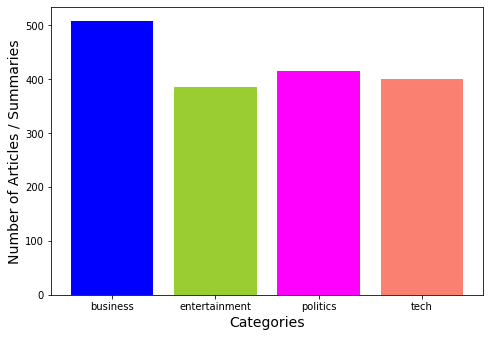

In [31]:
dataset_loader = DatasetLoader(PreprocessingTechnique.NONE)
dataset_loader.visualize_dataset()

# TextRank

In [9]:
'''
This code was adapted from the following source of code: 
https://github.com/davidadamojr/TextRank
'''

class TextRank:
  def __init__(self):
    pass

  def filter_for_tags(self, tagged, tags=['NN', 'JJ', 'NNP']):
    return [item for item in tagged if item[1] in tags]

  def normalize(self, tagged):
    return [(item[0].replace('.', ''), item[1]) for item in tagged]

  def unique_everseen(self, iterable, key=None):
    seen = set()
    seen_add = seen.add
    if key is None:
        def key(x): return x
    for element in iterable:
        k = key(element)
        if k not in seen:
            seen_add(k)
            yield element

  def build_graph(self, nodes):
    gr = nx.Graph()  
    gr.add_nodes_from(nodes)
    nodePairs = list(itertools.combinations(nodes, 2))

    for pair in nodePairs:
        firstString = pair[0]
        secondString = pair[1]
        levDistance = editdistance.eval(firstString, secondString)
        gr.add_edge(firstString, secondString, weight=levDistance)

    return gr
        
  def extract_sentences(self, text, summary_length=100, clean_sentences=False, language='english'):
    sent_detector = nltk.data.load('tokenizers/punkt/' + language + '.pickle')
    sentence_tokens = sent_detector.tokenize(text.strip())
    graph = self.build_graph(sentence_tokens)
    calculated_page_rank = nx.pagerank(graph, weight='weight')
    sentences = sorted(calculated_page_rank, key=calculated_page_rank.get, reverse=True)

    summary = ' '.join(sentences)
    summary_words = summary.split()
    summary_words = summary_words[0: summary_length]
    dot_indices = [idx for idx, word in enumerate(summary_words) if word.find('.') != -1]
    if clean_sentences and dot_indices:
        last_dot = max(dot_indices) + 1
        summary = ' '.join(summary_words[0: last_dot])
    else:
        summary = ' '.join(summary_words)

    return summary

# Evaluation

In [10]:
class ExtractiveTextSummarizationModel(Enum):
  TEXTRANK = 'TextRank'
  BERT = 'Bert'

In [32]:
class Evaluator:
  """
  A class used to evaluate the two chosen algorithms using the rouge metric

  ...

  Attributes
  ----------
  __preprocessing_technique : PreprocessingTechnique
      an enum used to represent which NLP preprocessing technique is selected
   __categories : list[str]
      a list of strings representing each category of the dataset
  __dataset: dict{str: list[DataItem]}
      returns the whole dataset as a dictionary with string keys (representing a category) and lists of DataItem as values (representing all article/summary pairs for the given category)
 
  Methods
  -------
  __load_dataset
      helper method to call the appropriate method from the DatasetLoader class to populate the __dataset property
  __get_rouge_scores
      method that returns the rouge scores as a list
  __display_rouge_metric_bar_chart
      display a bar chart showing the rouge-l and rouge-1 results
  display_rouge_metric_results
      displays a table of the rouge-l and rouge-1 results for the given data from a specifed model
  display_human_verifiable_results
      displays random pairs of model-generated and human-written summaries for vizual evaluation
  """

  def __init__(self, preprocessing_technique=PreprocessingTechnique.NONE):
    self.__preprocessing_technique = preprocessing_technique
    self.__categories = [category.name.lower() for category in DatasetCategory]
    self.__dataset = {}
    self.__load_dataset()

  def __load_dataset(self):
    dataset_loader = DatasetLoader(self.__preprocessing_technique)
    self.__dataset = dataset_loader.load_dataset()

  def __get_rouge_scores(self, summarization_model, data_items):
    textrank = TextRank()
    bert = Summarizer()
    rouge = Rouge()
    
    summarized_articles = {'model': [], 'reference': []}

    for data_item in data_items:
      article = data_item.get_article()
      
      if summarization_model == ExtractiveTextSummarizationModel.TEXTRANK:
        summary = textrank.extract_sentences(article)

      elif summarization_model == ExtractiveTextSummarizationModel.BERT:
        summary = bert(article)
      
      summarized_articles['model'].append(summary)
      summarized_articles['reference'].append(data_item.get_summary())

    scores = rouge.get_scores(summarized_articles['model'], summarized_articles['reference'], avg=True)
    
    return scores

  def __display_rouge_metric_bar_chart(self, rouge_scores):
    bar_width = 0.25
    fig = plt.subplots(figsize = (12, 8))
    
    recall = [rouge_scores['rouge-1']['r'], rouge_scores['rouge-l']['r']]
    precision = [rouge_scores['rouge-1']['p'], rouge_scores['rouge-l']['p']]
    f1_score = [rouge_scores['rouge-1']['f'], rouge_scores['rouge-l']['f']]
    
    bar1 = np.arange(len(recall))
    bar2 = [x + bar_width for x in bar1]
    bar3 = [x + bar_width for x in bar2]
    
    plt.bar(bar1, recall, color ='yellowgreen', width = bar_width, edgecolor ='grey', label ='recall')
    plt.bar(bar2, precision, color ='magenta', width = bar_width, edgecolor ='grey', label ='precision')
    plt.bar(bar3, f1_score, color ='salmon', width = bar_width, edgecolor ='grey', label ='f1_score')
    
    plt.xlabel('Metric', fontsize = 14)
    plt.ylabel('Value', fontsize = 14)
    plt.xticks([r + bar_width for r in range(len(recall))], ['ROUGE-1', 'ROUGE-L'])
    
    plt.legend()
    plt.show()

  def display_rouge_metric_results(self, summarization_model, by_category=False, show_bar_chart=False):
    print('Extractive Text Summarization Model:', summarization_model.value)
    print('By Category:', by_category)
    print('Preprocessing:', self.__preprocessing_technique.value)

    rouge_score = lambda metric: [('Rouge-' + metric), scores[('rouge-' + metric)]['f'], scores[('rouge-' + metric)]['p'], scores[('rouge-' + metric)]['r']]

    if by_category:
      for category in self.__categories:
        print('Category:', category)
        scores = self.__get_rouge_scores(summarization_model, self.__dataset[category])
        if show_bar_chart:
          self.__display_rouge_metric_bar_chart(scores)
        print(tabulate([rouge_score('1'), rouge_score('l')], ["", "f1_score", "precision", "recall"], tablefmt="grid"))
    else:
      all_category_items = self.__dataset.values()
      all_category_items = [data_item_sub_list for sub_list in all_category_items for data_item_sub_list in sub_list]
      scores = self.__get_rouge_scores(summarization_model, all_category_items)
      if show_bar_chart:
        self.__display_rouge_metric_bar_chart(scores)
      print(tabulate([rouge_score('1'), rouge_score('l')], ["", "f1_score", "precision", "recall"], tablefmt="grid"))

  def display_human_verifiable_results(self, summarization_model, num_items_to_display=10):
    print('Extractive Text Summarization Model:', summarization_model.value)

    textrank = TextRank()
    bert = Summarizer()
    category = random.choice(self.__categories)

    for data_item in self.__dataset[category]:
      num_items_to_display -= 1
      model_summary = textrank.extract_sentences(data_item.get_article())
      human_summary = data_item.get_summary()
      if num_items_to_display == 0:
        break

      print('\n', '--- Model Summary ---', '\n', model_summary)
      print('\n', '--- Human Summary ---', '\n', human_summary)

In [ ]:
evaluator = Evaluator(PreprocessingTechnique.NONE)
evaluator.display_human_verifiable_results(ExtractiveTextSummarizationModel.BERT)

In [ ]:
evaluator = Evaluator(PreprocessingTechnique.NONE)
evaluator.display_rouge_metric_results(ExtractiveTextSummarizationModel.TEXTRANK, show_bar_chart=True)
evaluator.display_rouge_metric_results(ExtractiveTextSummarizationModel.BERT, show_bar_chart=True)
evaluator.display_rouge_metric_results(ExtractiveTextSummarizationModel.TEXTRANK, by_category=True)
evaluator.display_rouge_metric_results(ExtractiveTextSummarizationModel.BERT, by_category=True)

In [ ]:
evaluator = Evaluator(PreprocessingTechnique.STOP_WORDS)
evaluator.display_rouge_metric_results(ExtractiveTextSummarizationModel.TEXTRANK, show_bar_chart=True)
evaluator.display_rouge_metric_results(ExtractiveTextSummarizationModel.BERT, show_bar_chart=True)
evaluator.display_rouge_metric_results(ExtractiveTextSummarizationModel.TEXTRANK, by_category=True)
evaluator.display_rouge_metric_results(ExtractiveTextSummarizationModel.BERT, by_category=True)

In [ ]:
evaluator = Evaluator(PreprocessingTechnique.LOWER_CASE)
evaluator.display_rouge_metric_results(ExtractiveTextSummarizationModel.TEXTRANK, show_bar_chart=True)
evaluator.display_rouge_metric_results(ExtractiveTextSummarizationModel.BERT, show_bar_chart=True)
evaluator.display_rouge_metric_results(ExtractiveTextSummarizationModel.TEXTRANK, by_category=True)
evaluator.display_rouge_metric_results(ExtractiveTextSummarizationModel.BERT, by_category=True)